# Исследование данных о компьютерных играх

### Изучение общей информации. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import matplotlib.ticker as ticker
import warnings 

In [2]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')

In [3]:
data.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Общая информация о данных:

- таблица состоит из 11 столбцов и 16 715 строк;
- используются следующие типы данных: дробные числа (6 столбцов), и строковые значения (5 столбцов);
- пропуски встречаются в столбцах: Name, Year_of_Release, Genre, Critic_Score, User_Score и Rating.

### Предобработка данных

Проверка на явные дубликкаты:

In [5]:
data.duplicated(subset=['Name','Platform','Year_of_Release']).sum()

2

In [6]:
data = data.drop_duplicates(subset=['Name','Platform','Year_of_Release'], keep='first',inplace=False, ignore_index=False)

Явные дубликаты удалены. <br>

#### Заменим названия столбцов (приведем к нижнему регистру)

In [7]:
data = data.rename(
columns={
'Name': 'name',
'Platform': 'platform',
'Year_of_Release': 'year_of_release',
'Genre': 'genre',
'NA_sales': 'na_sales',
'EU_sales': 'eu_sales',
'JP_sales': 'jp_sales',
'Other_sales': 'other_sales',
'Critic_Score': 'critic_score',
'User_Score': 'user_score',
'Rating': 'rating'}
)

#### Преобразуем данные в нужные типы: <br>
Year_of_Release — год выпуска к типу int<br> 
Critic_Score — оценка критиков, обычно целочисленная - к типу int <br>
User_Score — оценка пользователей к типу float

In [8]:
data['year_of_release'] = data['year_of_release'].astype('Int64')
data['critic_score'] = data['critic_score'].astype('Int64')
data['user_score'] = pd.to_numeric(data['user_score'], errors='coerce').astype('float64')

#### Обработка пропусков: 

In [9]:
data.isna().sum()

name                  1
platform              0
year_of_release     269
genre                 1
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8577
user_score         9124
rating             6765
dtype: int64

Строки с пропусками в столбцах название, год выхода и жанр сразу же удалим - заполнить эти данные расчетными показателями нельзя.

In [10]:
data.dropna(subset = ['name','genre', 'year_of_release'], inplace = True)

In [11]:
# check
# пропущенные значения бары

def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (19,6), legend = False, fontsize = 16)
            .set_title('Доля пропущенных значений в столбцах, %' + "\n", fontsize = 22, color = 'SteelBlue')    
        );    
    except:
        print('пропусков не осталось :) или произошла ошибка в первой части функции ')

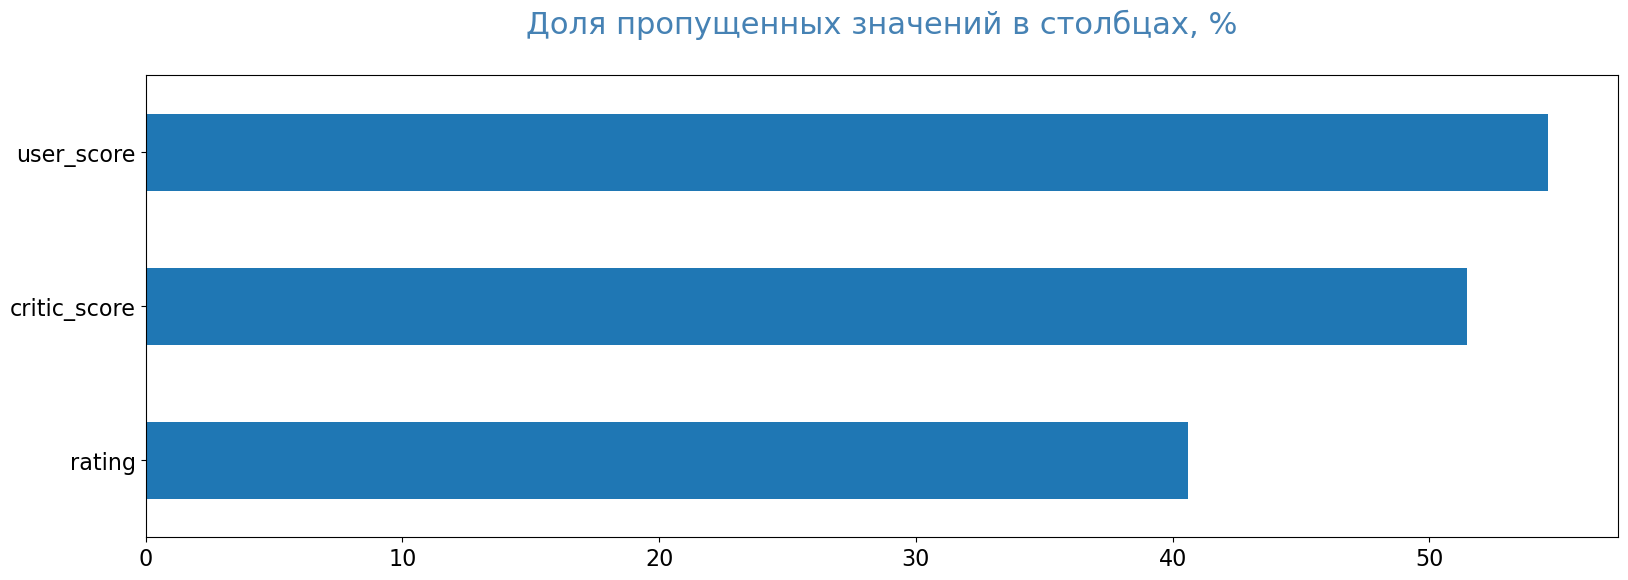

In [12]:
pass_value_barh(data)

В наборе данных очень много пропусков в оценках пользователей и критиков, а также в возрастном рейтинге игры.<br>  Аббревиатуру 'tbd' в столбце с оценкой пользователей, а также пропуски в этом столбце и в столбце с оценкой критиков заменим на заглушку (-1).

In [13]:
data.loc[(data['user_score'] == 'tbd')] = -1
data['user_score'] = data['user_score'].fillna(-1)
data['critic_score'] = data['critic_score'].fillna(-1)
data['rating'] = data['rating'].fillna('region')

In [14]:
data.isna().sum()

name               0
platform           0
year_of_release    0
genre              0
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score       0
user_score         0
rating             0
dtype: int64

#### Дополним столбец "Суммарные продажи во всех регионах" 

In [15]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

In [16]:
data.head(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1,-1.0,region,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1,-1.0,region,31.38


Итог по разделу предобработки:<br>
заменены названия столбцов, <br>
удалены явные дубликаты, <br>
преобразованы тип данных в ряде столбцов, <br>
пропуски в столбцах рейтинга, оценок пользователей и критиков заполнены "заглушками".

### Исследовательский анализ данных

Посмотрим, сколько игр выпускалось в разные годы. <br>

In [17]:
data['year_of_release'].unique()

<IntegerArray>
[2006, 1985, 2008, 2009, 1996, 1989, 1984, 2005, 1999, 2007, 2010, 2013, 2004,
 1990, 1988, 2002, 2001, 2011, 1998, 2015, 2012, 2014, 1992, 1997, 1993, 1994,
 1982, 2016, 2003, 1986, 2000, 1995, 1991, 1981, 1987, 1980, 1983]
Length: 37, dtype: Int64

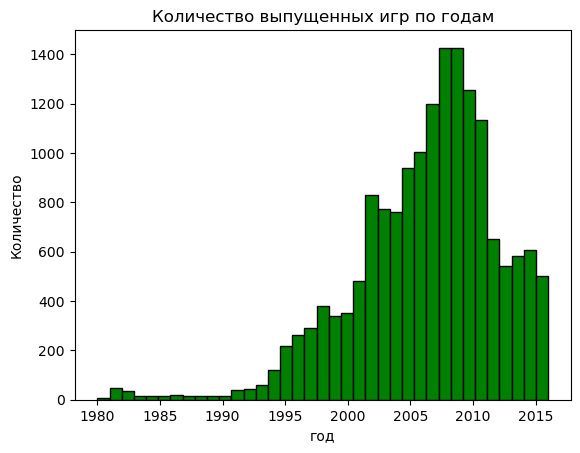

In [18]:
plt.hist(data['year_of_release'], color = 'green', edgecolor = 'black', bins=37);
plt.title('Количество выпущенных игр по годам')
plt.xlabel('год');
plt.ylabel('Количество');

Посмотрим, как менялись продажи по платформам. Выберем платформы с наибольшими суммарными продажами и построим распределение по годам. 

In [19]:
platform_data = data.pivot_table(index='platform', values='total_sales', aggfunc=['sum', 'count'])
platform_data.columns = ['sum', 'count']
platform_data = platform_data.sort_values(by='count', ascending=False)

In [20]:
platform_data.head(10).round(2)

,sum,count
platform,,
PS2,1233.56,2127
DS,802.78,2121
PS3,931.33,1305
Wii,891.18,1286
X360,961.24,1232
PSP,289.53,1193
PS,727.58,1190
PC,255.76,957
GBA,312.88,811


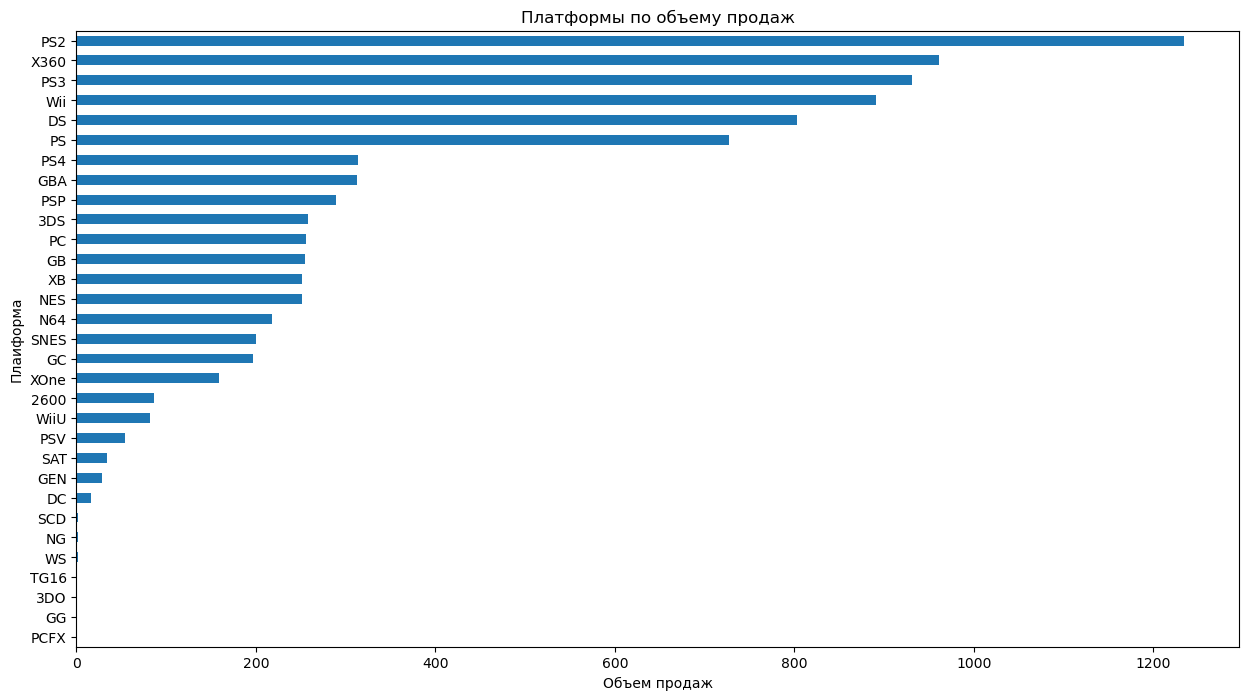

In [21]:
data_sorted = data.groupby("platform")["total_sales"].sum().sort_values()
data_sorted.plot(figsize=(15,8), kind="barh");
plt.title('Платформы по объему продаж')
plt.xlabel('Объем продаж');
plt.ylabel('Плаиформа');

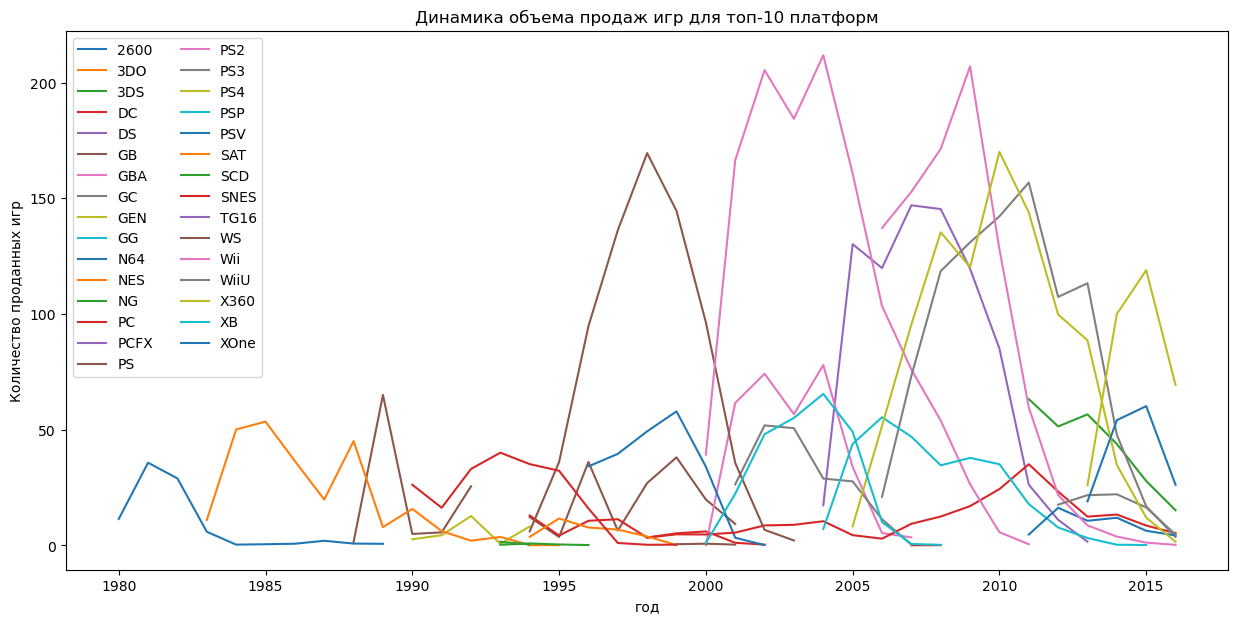

In [22]:
platform = platform_data.index.to_list()
sorted_platform = data.loc[data['platform'].isin(platform)]
sorted_platform_pivot = sorted_platform.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')
sorted_platform_pivot.plot(figsize=(15,7))
plt.title('Динамика объема продаж игр для топ-10 платформ')
plt.xlabel('год')
plt.ylabel('Количество проданных игр')
plt.legend(bbox_to_anchor=[0, 1], loc='upper left', ncol=2)
plt.show()

Характерный срок, за который появляются новые и исчезают старые платформы, в разные годы составляет примерно от 5 до 10 лет (за исключением ПК). <br>
Так как мы планируем компанию на 2017 год, возьмем данные за актуальный период - с 2013 года. В дальнейшей работе используем данные с 2013 года.

In [23]:
data['year_of_release'] = data['year_of_release'].astype('int')
new_data = data.query('year_of_release > 2013')
potential_platform = new_data.pivot_table(index='platform', values='total_sales', aggfunc=['sum', 'count'])
potential_platform.columns = ['sum', 'count']
potential_platforms = potential_platform.sort_values(by='count', ascending=False).head(25).round(2)
potential_platforms

,sum,count
platform,,
PS4,288.15,376
PSV,22.40,295
XOne,140.36,228
PS3,68.18,219
3DS,86.68,212
PC,27.05,151
X360,48.22,111
WiiU,42.98,73
PSP,0.36,13


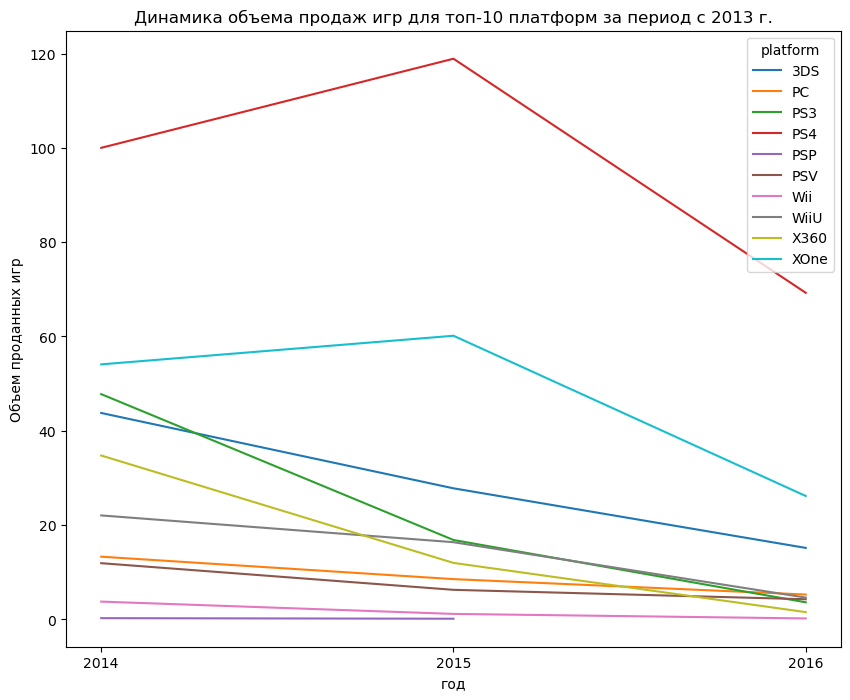

In [24]:
actual_data = data.query('year_of_release > 2013')
new_platform = potential_platforms.index.to_list()
new_sorted_platform = actual_data.loc[actual_data['platform'].isin(new_platform)]
new_sorted_platform_pivot = new_sorted_platform.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')
ax = new_sorted_platform_pivot.plot(figsize = (10,8));
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.title('Динамика объема продаж игр для топ-10 платформ за период с 2013 г.')
plt.xlabel('год');
plt.ylabel('Объем проданных игр');

К числу потенциально прибыльных платформ отнесем: PS4, XOne, WiiU, PC, 3DS.
Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам.<br>

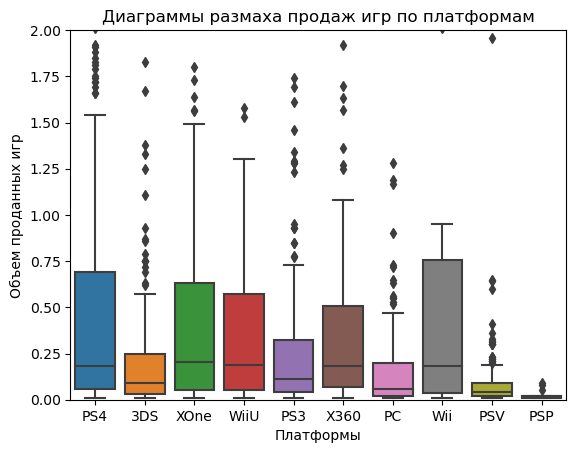

In [25]:
sns.boxplot(x="platform", y="total_sales", data=actual_data);
plt.ylim(0, 2)
plt.title('Диаграммы размаха продаж игр по платформам')
plt.xlabel('Платформы');
plt.ylabel('Объем проданных игр');

С помощью диаграмм "ящик с усами" можно оценить насколько предсказуемы будут продажи игр на разных платформах. Аномальный значения - это нетипично удачные игры.<br>
Кроме того отметим, что на ПК, как и на WiiU и на Xone не выходило игр,которые были проданы больше 8 млн раз. 

Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами. <br>

Расчет по Платформе 3DS


user_score     0.215193
total_sales    1.000000
Name: total_sales, dtype: float64

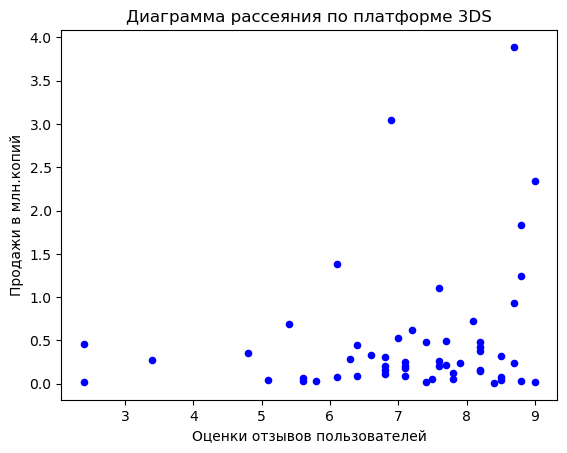

critic_score    0.314117
total_sales     1.000000
Name: total_sales, dtype: float64

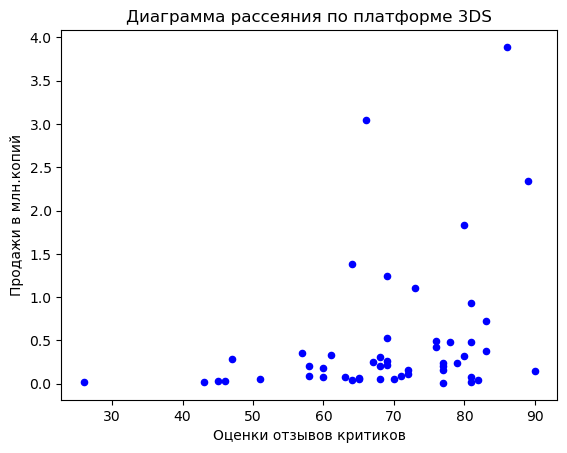

Расчет по Платформе PC


user_score    -0.071597
total_sales    1.000000
Name: total_sales, dtype: float64

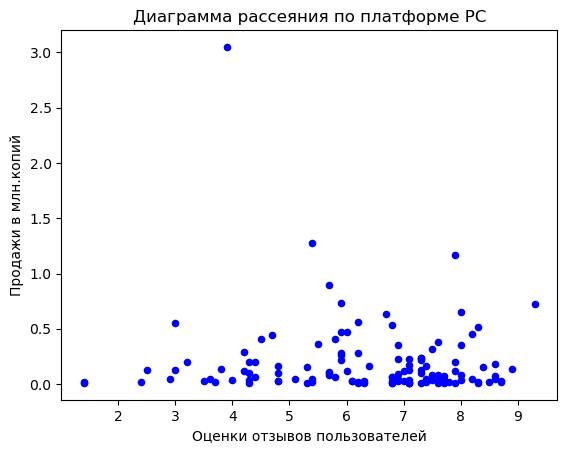

critic_score    0.174634
total_sales     1.000000
Name: total_sales, dtype: float64

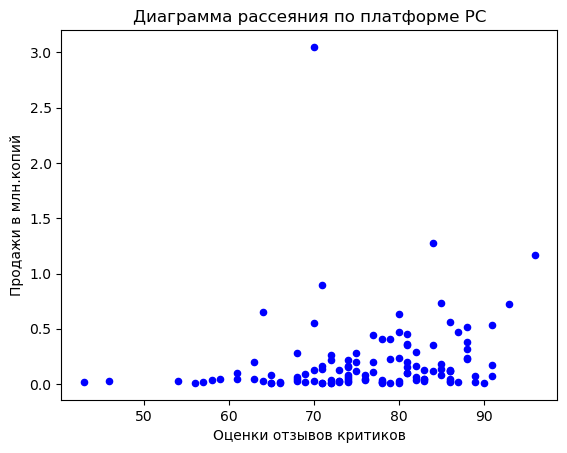

Расчет по Платформе PS3


user_score    -0.166761
total_sales    1.000000
Name: total_sales, dtype: float64

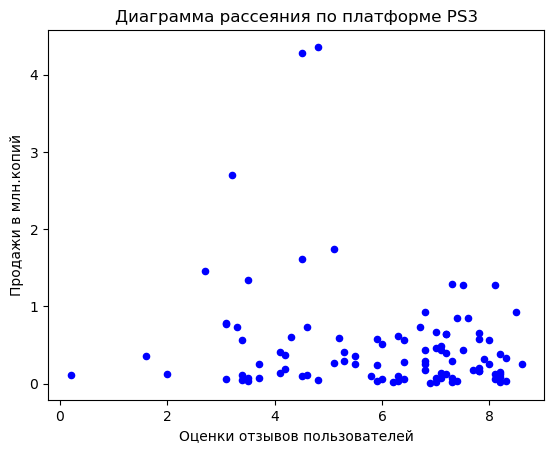

critic_score    0.446575
total_sales     1.000000
Name: total_sales, dtype: float64

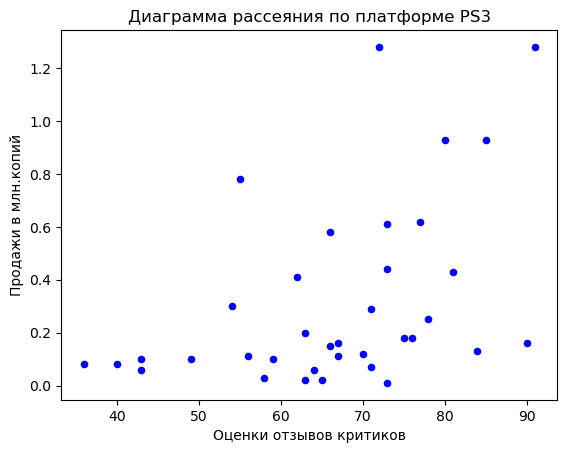

Расчет по Платформе PS4


user_score    -0.040132
total_sales    1.000000
Name: total_sales, dtype: float64

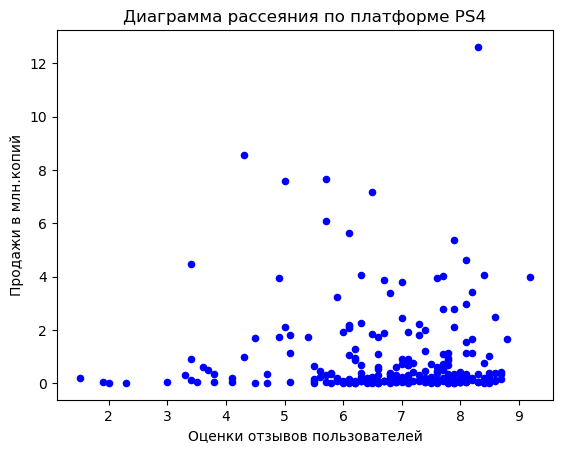

critic_score    0.402661
total_sales     1.000000
Name: total_sales, dtype: float64

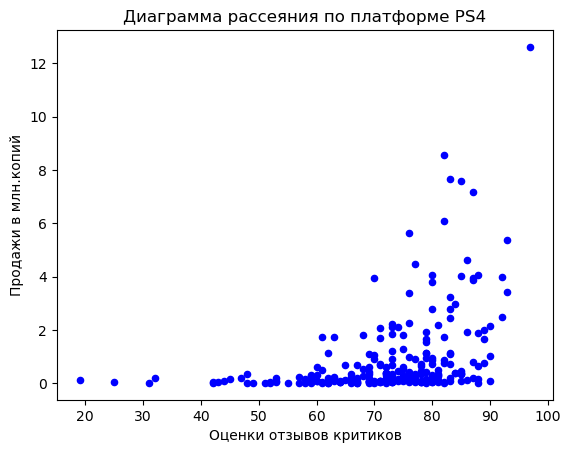

Расчет по Платформе PSP
Для платформы PSP не хватает данных для построения диаграммы и расчета корреляции отзывов пользователей
Для платформы PSP не хватает данных для построения диаграммы и расчета корреляции отзывов критиков
Расчет по Платформе PSV


user_score    -0.168455
total_sales    1.000000
Name: total_sales, dtype: float64

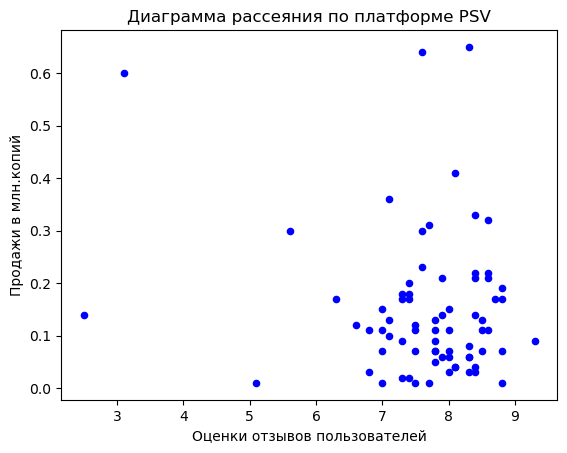

critic_score    0.042665
total_sales     1.000000
Name: total_sales, dtype: float64

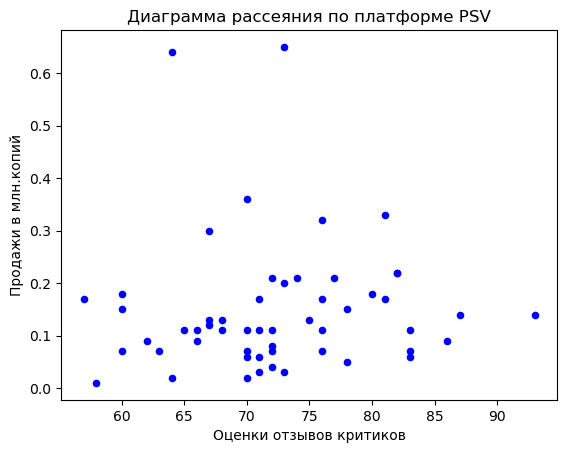

Расчет по Платформе Wii
Для платформы Wii не хватает данных для построения диаграммы и расчета корреляции отзывов пользователей
Для платформы Wii не хватает данных для построения диаграммы и расчета корреляции отзывов критиков
Расчет по Платформе WiiU


user_score     0.407926
total_sales    1.000000
Name: total_sales, dtype: float64

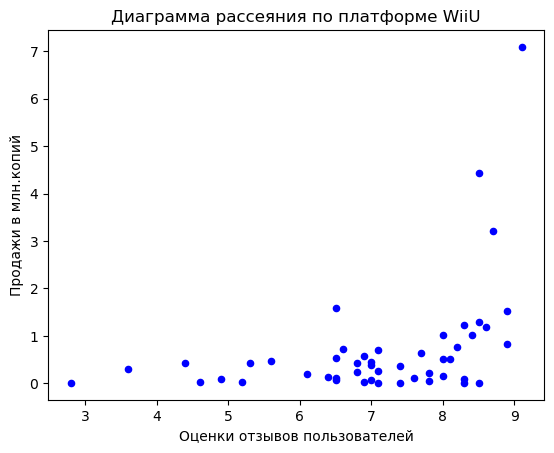

critic_score    0.370201
total_sales     1.000000
Name: total_sales, dtype: float64

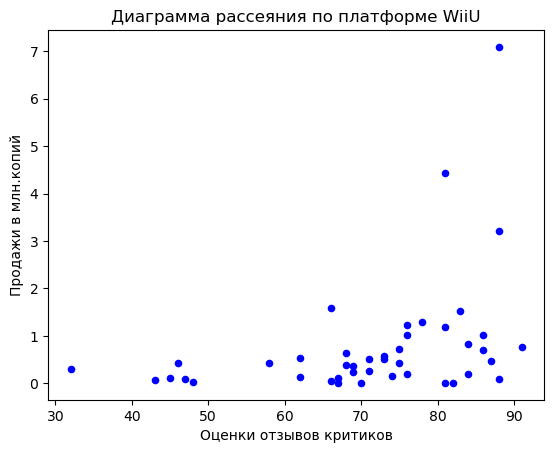

Расчет по Платформе X360


user_score    -0.138445
total_sales    1.000000
Name: total_sales, dtype: float64

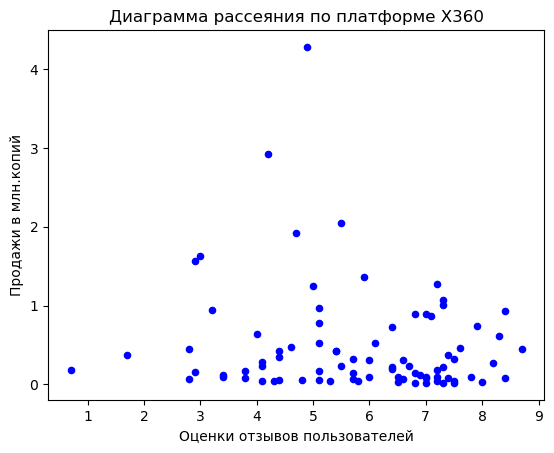

critic_score    0.525723
total_sales     1.000000
Name: total_sales, dtype: float64

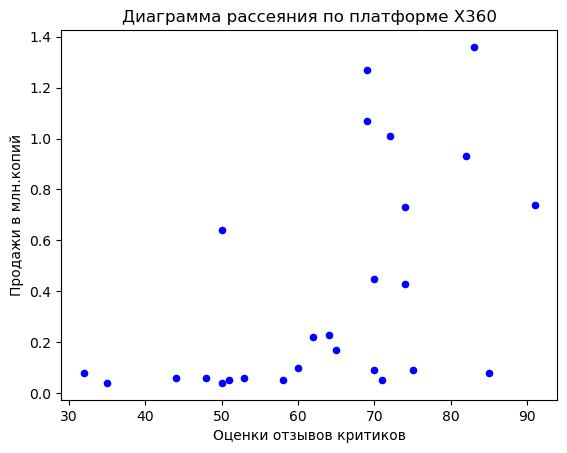

Расчет по Платформе XOne


user_score    -0.070384
total_sales    1.000000
Name: total_sales, dtype: float64

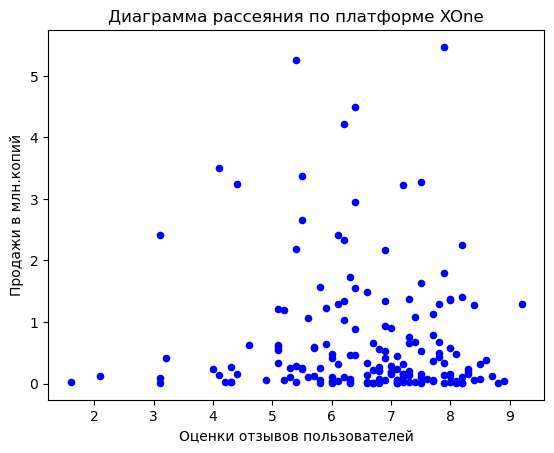

critic_score    0.428677
total_sales     1.000000
Name: total_sales, dtype: float64

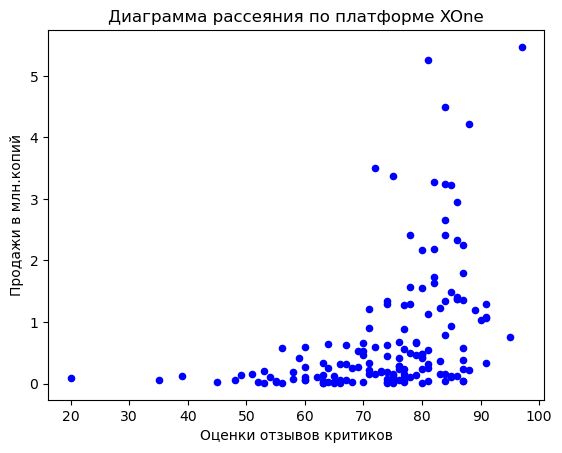

In [26]:

df_sc, y = actual_data.copy(), 'total_sales'
for platform, games_on_pl in df_sc.groupby('platform'):
    print('='*60)
    print('Расчет по Платформе',platform)
    # Считаем сколько в колонке не пустых отзывов
    not_user = len(games_on_pl[(games_on_pl.user_score != -1)&(games_on_pl['user_score'].notna() == True)])
    not_critic = len(games_on_pl[(games_on_pl.critic_score != -1)&(games_on_pl['user_score'].notna() == True)])
    sum_not = 3 # Задаем количество не пустых значений для вывода диаграммы и расчета корреляции
    if not_user > sum_not:
        games_on_pl[games_on_pl.user_score != -1].plot(kind='scatter', x='user_score', y=y, color='b')
        display(games_on_pl[games_on_pl.user_score != -1][['user_score', y]].corr()[y])
        plt.xlabel('Оценки отзывов пользователей')
        plt.ylabel('Продажи в млн.копий')
        plt.title('Диаграмма рассеяния по платформе '+platform)
        plt.show()
    else:
        print('Для платформы',platform, 'не хватает данных для построения диаграммы и расчета корреляции отзывов пользователей')
    if not_critic > sum_not:
        games_on_pl[games_on_pl.critic_score != -1].plot(kind='scatter', x='critic_score', y=y, color='b')
        display(games_on_pl[games_on_pl.critic_score != -1][['critic_score', y]].corr()[y])
        plt.xlabel('Оценки отзывов критиков')
        plt.ylabel('Продажи в млн.копий')
        plt.title('Диаграмма рассеяния по платформе '+platform)
        plt.show()
    else:
        print('Для платформы',platform, 'не хватает данных для построения диаграммы и расчета корреляции отзывов критиков')

Зависимость между оценками критиков и пользователей и объемом продаж выражено слабо (а для некоторых платформ зависимость и вовсе обратная) для выбранных в качестве потенциальных платформ. Оценки пользователей менее эффективно определяют успешные игры, в то время корреляция между продажими и оценками критиков существеннее, но тем неменее не такая сильная связь, чтобы основывать планирование рекламной кампании на оценках.

<br>
Посмотрим на общее распределение игр по жанрам. Так как в разных жанрах выпускаю разное количество игр, важно также оценить какой объем продаж в среднем у игры. Игр в жанре Экшн количественно больше и они в абсолютных показателях продаются больше, но в среднем самый продаваемый жанр - шутеры.

In [27]:
genre_data = actual_data.pivot_table(index='genre', values='total_sales', aggfunc=['sum', 'count', 'mean'])
genre_data.columns = ['sum', 'count', 'mean']
profit_genre = genre_data.sort_values(by='count', ascending=False).head(10).round(2)
profit_genre

,sum,count,mean
genre,,,
Action,199.36,619,0.32
Role-Playing,101.44,221,0.46
Adventure,17.55,185,0.09
Sports,109.48,161,0.68
Shooter,170.94,128,1.34
Misc,37.55,113,0.33
Racing,27.52,69,0.40
Fighting,28.22,60,0.47
Simulation,13.13,44,0.30


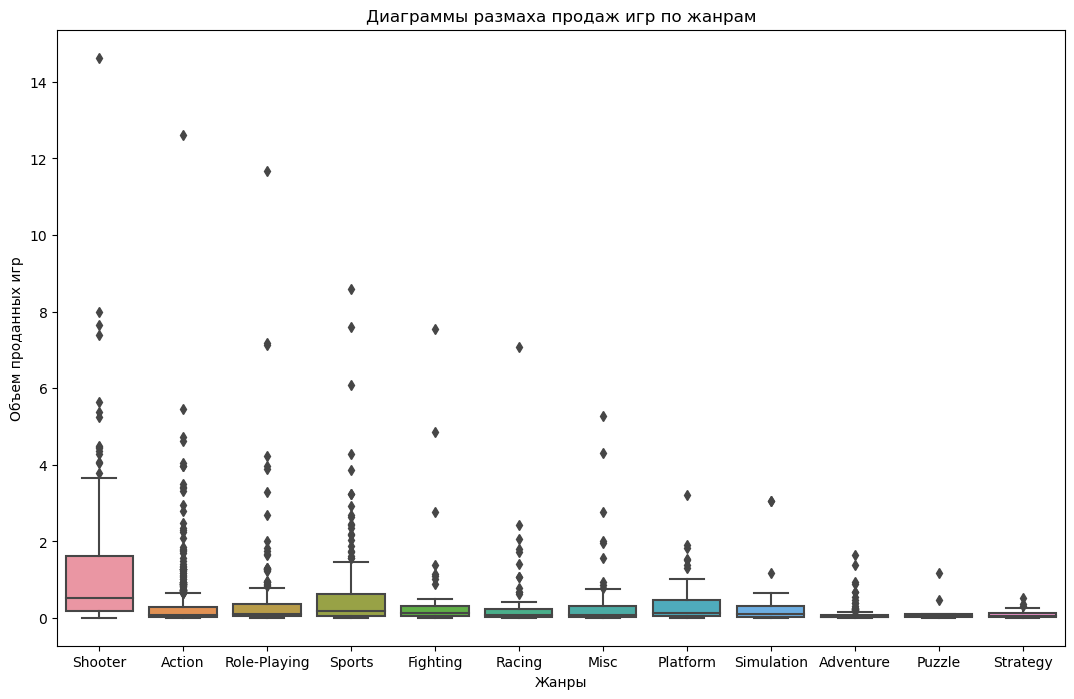

In [28]:
plt.figure(figsize=(13, 8))
sns.boxplot(x="genre", y="total_sales", data=actual_data);
plt.title('Диаграммы размаха продаж игр по жанрам')
plt.xlabel('Жанры');
plt.ylabel('Объем проданных игр');

### Портрет пользователя каждого региона

#### Самые популярные платформы (топ-5).

In [29]:
na_top_platform = new_data.pivot_table(index='platform', values='na_sales', aggfunc='sum')
na_top_platform.columns = ['sum']
na_top_platform = na_top_platform.sort_values(by='sum', ascending=False).head(5).round(2)

na_top_platform = list(na_top_platform.index.values )
na_top_platform

['PS4', 'XOne', 'X360', '3DS', 'PS3']

In [30]:
eu_top_platform = new_data.pivot_table(index='platform', values='eu_sales', aggfunc='sum')
eu_top_platform.columns = ['sum']
eu_top_platform = eu_top_platform.sort_values(by='sum', ascending=False).head(5).round(2)

eu_top_platform = list(eu_top_platform.index.values )
eu_top_platform

['PS4', 'XOne', 'PS3', 'PC', '3DS']

In [31]:
jp_top_platform = new_data.pivot_table(index='platform', values='jp_sales', aggfunc='sum')
jp_top_platform.columns = ['sum']
jp_top_platform = jp_top_platform.sort_values(by='sum', ascending=False).head(5).round(2)

jp_top_platform = list(jp_top_platform.index.values )
jp_top_platform

['3DS', 'PS4', 'PSV', 'PS3', 'WiiU']

In [32]:
def na_categorize_platform(platform):
    if platform in na_top_platform:
        return platform
    else:
        return 'Other_platform'

In [33]:
new_data['na_platform_pie'] = new_data['platform'].apply(na_categorize_platform)

/var/folders/jf/fc0h52cn4szf8thmzw2fn77r0000gn/T/ipykernel_18020/115363907.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['na_platform_pie'] = new_data['platform'].apply(na_categorize_platform)


In [34]:
def eu_categorize_platform(platform):
    if platform in eu_top_platform:
        return platform
    else:
        return 'Other_platform'

In [35]:
new_data['eu_platform_pie'] = new_data['platform'].apply(eu_categorize_platform)

/var/folders/jf/fc0h52cn4szf8thmzw2fn77r0000gn/T/ipykernel_18020/3941292773.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['eu_platform_pie'] = new_data['platform'].apply(eu_categorize_platform)


In [36]:
def jp_categorize_platform(platform):
    if platform in jp_top_platform:
        return platform
    else:
        return 'Other_platform'

In [37]:
new_data['jp_platform_pie'] = new_data['platform'].apply(jp_categorize_platform)

/var/folders/jf/fc0h52cn4szf8thmzw2fn77r0000gn/T/ipykernel_18020/718084485.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['jp_platform_pie'] = new_data['platform'].apply(jp_categorize_platform)


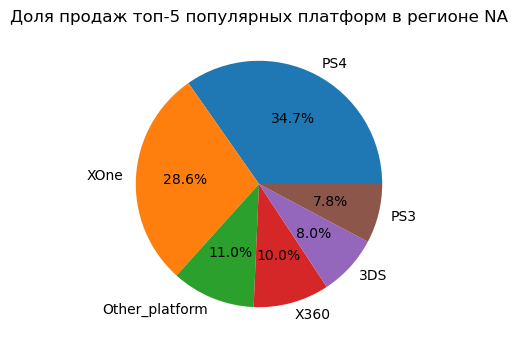

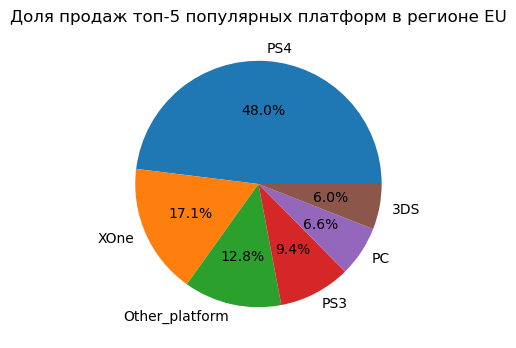

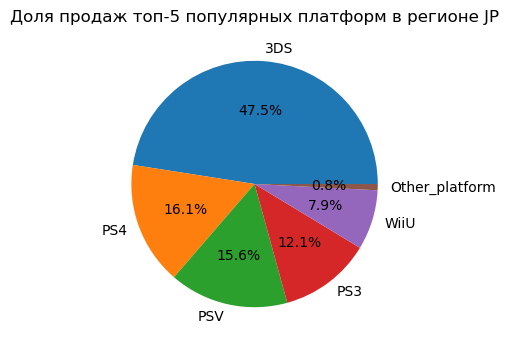

In [38]:
na_top_platform = new_data.pivot_table(index='na_platform_pie', values='na_sales', aggfunc='sum')
na_top_platform.columns = ['sum']
na_top_platform = na_top_platform.sort_values(by='sum', ascending=False)

eu_top_platform = new_data.pivot_table(index='eu_platform_pie', values='eu_sales', aggfunc='sum')
eu_top_platform.columns = ['sum']
eu_top_platform = eu_top_platform.sort_values(by='sum', ascending=False)

jp_top_platform = new_data.pivot_table(index='jp_platform_pie', values='jp_sales', aggfunc='sum')
jp_top_platform.columns = ['sum']
jp_top_platform = jp_top_platform.sort_values(by='sum', ascending=False)

na_top_platform.plot(kind='pie',autopct='%1.1f%%', subplots=True, figsize=(4, 4))
plt.title("Доля продаж топ-5 популярных платформ в регионе NA")
plt.legend('', frameon=False)
plt.ylabel("")
eu_top_platform.plot(kind='pie',autopct='%1.1f%%', subplots=True, figsize=(4, 4))
plt.title("Доля продаж топ-5 популярных платформ в регионе EU")
plt.legend('', frameon=False)
plt.ylabel("")
jp_top_platform.plot(kind='pie',autopct='%1.1f%%', subplots=True, figsize=(4, 4))
plt.title("Доля продаж топ-5 популярных платформ в регионе JP")
plt.legend('', frameon=False)
plt.ylabel("")
plt.show()

В топ-5 консолей во всез трех регионах входят PS3 и PS4.<br>
В европейском регионе почти половина продаж приходится на PS4, вышедшей на рынок тремя годами ранее.<br>
В азиатском регионе преобладают портативные консоли (3DS, WiiU  и PSV).<br>

#### Самые популярные жанры (топ-5)<br>


In [39]:
na_top_genre = new_data.pivot_table(index='genre', values='na_sales', aggfunc='sum')
na_top_genre.columns = ['sum']
na_top_genre = na_top_genre.sort_values(by='sum', ascending=False).head(5).round(2)

na_top_genre = list(na_top_genre.index.values )

eu_top_genre = new_data.pivot_table(index='genre', values='eu_sales', aggfunc='sum')
eu_top_genre.columns = ['sum']
eu_top_genre = eu_top_genre.sort_values(by='sum', ascending=False).head(5).round(2)

eu_top_genre = list(eu_top_genre.index.values )

jp_top_genre = new_data.pivot_table(index='genre', values='jp_sales', aggfunc='sum')
jp_top_genre.columns = ['sum']
jp_top_genre = jp_top_genre.sort_values(by='sum', ascending=False).head(5).round(2)

jp_top_genre= list(jp_top_genre.index.values )

In [40]:
def na_categorize_genre(genre):
    if genre in na_top_genre:
        return genre
    else:
        return 'Other_genre'
    
def eu_categorize_genre(genre):
    if genre in eu_top_genre:
        return genre
    else:
        return 'Other_genre'

def jp_categorize_genre(genre):
    if genre in jp_top_genre:
        return genre
    else:
        return 'Other_genre'

In [41]:
new_data['na_genre_pie'] = new_data['genre'].apply(na_categorize_genre)
new_data['eu_genre_pie'] = new_data['genre'].apply(eu_categorize_genre)
new_data['jp_genre_pie'] = new_data['genre'].apply(jp_categorize_genre)

/var/folders/jf/fc0h52cn4szf8thmzw2fn77r0000gn/T/ipykernel_18020/1468619872.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['na_genre_pie'] = new_data['genre'].apply(na_categorize_genre)
/var/folders/jf/fc0h52cn4szf8thmzw2fn77r0000gn/T/ipykernel_18020/1468619872.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['eu_genre_pie'] = new_data['genre'].apply(eu_categorize_genre)
/var/folders/jf/fc0h52cn4szf8thmzw2fn77r0000gn/T/ipykernel_18020/1468619872.py:3: SettingWithCopyWarning: 
A val

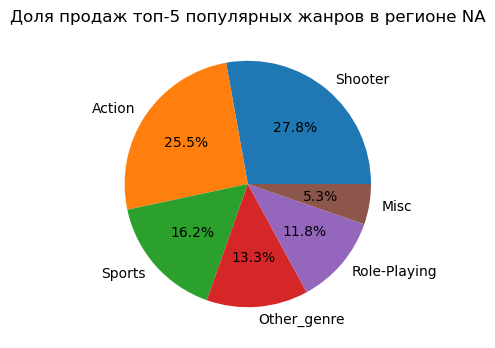

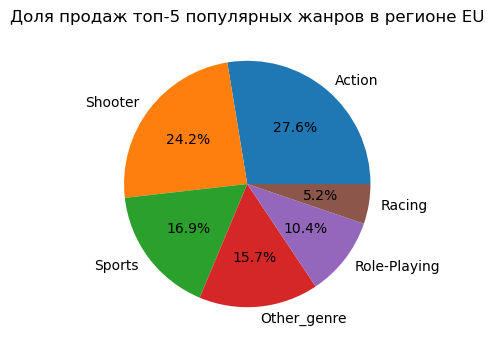

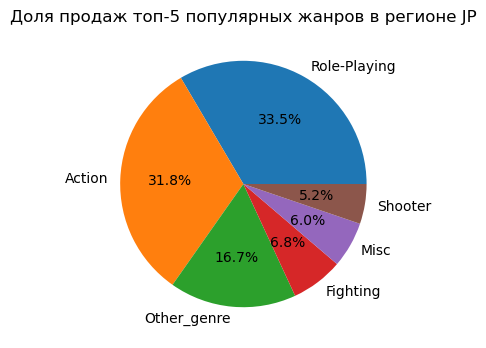

In [42]:
na_top_genre = new_data.pivot_table(index='na_genre_pie', values='na_sales', aggfunc='sum')
na_top_genre.columns = ['sum']
na_top_genre = na_top_genre.sort_values(by='sum', ascending=False)

eu_top_genre = new_data.pivot_table(index='eu_genre_pie', values='eu_sales', aggfunc='sum')
eu_top_genre.columns = ['sum']
eu_top_genre = eu_top_genre.sort_values(by='sum', ascending=False)

jp_top_genre = new_data.pivot_table(index='jp_genre_pie', values='jp_sales', aggfunc='sum')
jp_top_genre.columns = ['sum']
jp_top_genre = jp_top_genre.sort_values(by='sum', ascending=False)

na_top_genre.plot(kind='pie',autopct='%1.1f%%', subplots=True, figsize=(4, 4))
plt.title("Доля продаж топ-5 популярных жанров в регионе NA")
plt.legend('', frameon=False)
plt.ylabel("")
eu_top_genre.plot(kind='pie',autopct='%1.1f%%', subplots=True, figsize=(4, 4))
plt.title("Доля продаж топ-5 популярных жанров в регионе EU")
plt.legend('', frameon=False)
plt.ylabel("")
jp_top_genre.plot(kind='pie',autopct='%1.1f%%', subplots=True, figsize=(4, 4))
plt.title("Доля продаж топ-5 популярных жанров в регионе JP")
plt.legend('', frameon=False)
plt.ylabel("")
plt.show()

Для америкаского и европейского рынков популярные шанры и их доли по продажам практически идентичны: экшн, спорт, шутеры. А вот в азиатском регионе самым популярным жанром являются ролевые игры.

#### Влияние рейтинга ESRB на продажи в отдельном регионе<br>

In [43]:
new_data.pivot_table(index='rating', values=['na_sales','eu_sales','jp_sales'], aggfunc='sum')

,eu_sales,jp_sales,na_sales
rating,,,
E,58.06,8.94,50.74
E10+,26.16,4.46,33.23
M,93.44,8.01,96.42
T,34.07,14.78,38.95
region,58.95,56.90,64.72


«E» («Everyone») — «Для всех» <br>
«E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»<br>
«M» («Mature») — «Для взрослых»<br>
«T» («Teen») — «Подросткам»<br>
region - "заглушка"

В азиатском регионе значительно ниже продажи игр с рейтингом "Для взрослых" и "Для всех от 10 лет и старше". В этом регионе предпочитаются игры с рейтингом "Для всех" и "Подосткам". <br>

### Проверка гипотезы
#### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;<br>
Сформулируем две гипотезы: <br>
Нулевая: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые<br>
Альтернативная: Средние пользовательские рейтинги платформ Xbox One и PC не равны

In [44]:
xone_score = new_data[(new_data['platform']=='XOne') & (new_data['user_score']>0)]['user_score']
pc_score = new_data[(new_data['platform']=='PC') & (new_data['user_score']>0)]['user_score']

alpha = 0.05

results = st.ttest_ind(xone_score,pc_score, equal_var= False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.11601398086668832
Не получилось отвергнуть нулевую гипотезу


Посчитаем средний пользовательский рейтинг для двух платформ:

In [45]:
print(xone_score.mean())
print(pc_score.mean())

6.594545454545453
6.298360655737703



 Значение p-value равно почти 12%. Таким образом, не получилось опровергнуть Нулевую гипотезу.  У нас нет достаточных доказательств, чтобы сказать, что средние оценки по двум этим платформам различны. То есть, вероятностью получить различность рейтингов двух платформ 12%.

#### Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.<br>
Сформулируем гипотезы: <br>
Нулевая: Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») равны<br>
Альтернативная: Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

In [46]:
action_score = new_data[(new_data['genre']=='Action') & (new_data['user_score']>0)]['user_score']
sports_score = new_data[(new_data['genre']=='Sports') & (new_data['user_score']>0)]['user_score']

alpha = 0.05

results = st.ttest_ind(action_score, sports_score, equal_var= False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 1.1825550382644557e-14
Отвергаем нулевую гипотезу


Посчитаем средний пользовательский рейтинг для двух платформ:

In [47]:
print(action_score.mean())
print(sports_score.mean())

6.760606060606054
5.225196850393697


На имеющихся данных, на уровне значимости 5% есть основания отвергнуть нулевую гипотезу о равенстве средних значений пользовательских рейтингов (отзывов) жанров Action и Sports в пользу альтернативной гипотезы.

### Общий вывод

Для решения поставленных задач, осуществлены следующие шаги: <br>
- выполнена предобработку данных (устранены пропуски, изменены типы некоторых данных)
- добавлены в таблицу данные о суммарных продажах во всех регионах.
- проведен исследовательский анализ данных: выделены актуальные года для анализа, выделены потенциальные платформы и жанры в разных регионах. 
- составлены портреты пользователя каждого региона (NA, EU, JP)
- проверены две гиоптезы: о рейтингах для платформ Xbox и PS и о рейтингах двух разных жанров.

По результатам работы, для разработки рекламной компании на 2017 год предлагается использовать выделенные наиболее популярные платформы (PS4, XOne, WiiU), а также сконцентрировать внимание на самых популярных жанрах (Экшн, спорт и шутеры).<br>
И хотя можно учитывать выявленую региональную специфику азиатского региона при планировании компании (в этом регионе особое место занимают role-playing с возрастными рейтингами "для всех") - этот регион меньше европейского и американского рынка, возможно стоит отдать предпочтение этим двум рынкам (Европа и Америка).<br>
Зависимость между оценками как пользователей, так и критиков и объемом продаж не представляется существенной. Опираться на эти оценки при планировании бюджета не стоит.<br>